In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os

ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

In [5]:
def G(rho, p, P):
  return p*(1-rho/P)

# 1D parameter derivation:
# delta^2 / (1*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.05 # mm
tau = 0.2 # h
D = delta**2/(2*tau)
Du = Di = 1.5e-3 # mm^2/h
theta_u = Du/D
theta_i = Di/D
beta = 1.02e-1 # h-1
p = 1.87e-2 # h-1
q = 4.17e-2 # h-1
P = K = 1e3 # 1/mm^2
c_max = int(K*delta)
Ru = 2.6 # mm
Ri = 1 # mm
pop_unit = 1

In [6]:
def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*c_max)
  initial_i = int(.1*c_max)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size), dtype='int16')
  uint8 = np.iinfo(np.int16)
  print("max of dtype:", uint8.max, ". cmax: ",c_max)
  for i in range(size):
    if ((i-size/2)*delta)**2 <= (Ru)**2:
      domain[0][i] = initial_u
    if ((i-size/2)*delta)**2 <= (Ri)**2:
      domain[1][i] = initial_i
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)

max of dtype: 32767 . cmax:  50


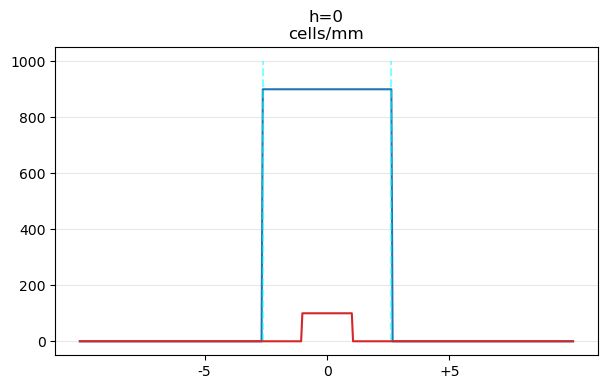

In [11]:
# define functions and parameters to save and plot results

def save_values(domain, h):
  np.save(f"{SIM_FOLDER}/sim{SIM}_h{h}.npy", domain)

size = int(1/delta * 10 * 2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]

def plot_domain(domain, h):
  radius_u = (Ru + h*np.sqrt(Du*p/2))/delta
  radius_i = (Ri + h*np.sqrt(Di*(beta-q)))/delta
  fig, ax = plt.subplots(figsize=(7, 4))

  # plot U
  plt.plot(np.divide(domain[0],delta), color="tab:blue")
  ax.set_xticks(ticks)
  ax.set_xticklabels(["-5","0","+5"],rotation=0)
  ax.title.set_text(f"h={h}\ncells/mm")
  plt.vlines([size//2 + radius_u, size//2 - radius_u], 0, c_max/delta, colors=["cyan"], linestyles="dashed", alpha=0.5)
  # plot I
  plt.plot(np.divide(domain[1],delta), color="tab:red")
  ax.yaxis.grid(alpha=0.3)
  # save and plot figure
  plt.savefig(f"{FIGURES_FOLDER}/pressure_sim{SIM}_h{h}.png", format='png', dpi=200)
  plt.show()

plot_domain(domain, 0)

In [12]:
# def simulation functions

def pressure_move(space_next, cell_type, i, p_unit):
  tot_cells_i = space_next[0][i] + space_next[1][i]
  tot_cells_right = space_next[0][i+1] + space_next[1][i+1]
  tot_cells_left = space_next[0][i-1] + space_next[1][i-1]

  prob_right = max((tot_cells_i-tot_cells_right), 0.)*theta_u/(2*c_max)
  prob_left = max((tot_cells_i-tot_cells_left), 0.)*theta_u/(2*c_max)
  prob_stay = max(1-prob_right-prob_left, 0.)
  prob_dist = [prob_stay, prob_right, prob_left]
  prob_dist /= np.sum(prob_dist)
  action = np.random.choice(["stay", "right", "left"], p=prob_dist)

  if action == "right" and i < space_next.shape[1]:
    space_next[cell_type][i] -= p_unit
    space_next[cell_type][i+1] += p_unit
  elif action == "left" and i > 0:
    space_next[cell_type][i] -= p_unit
    space_next[cell_type][i-1] += p_unit

def select_u_action(space, space_next, i):
  cell_type = 0
  # reproduce or die or nothing:
  if space[0][i]+space[1][i] >= c_max:
    prob_to_die = max(-tau*p*(1-(space[0][i]+space[1][i])/c_max), 0)
    prob_dist = [1-prob_to_die, prob_to_die]
    action = np.random.choice(["live","die"], p=prob_dist)
    if action == "die":
      space[0][i] -= pop_unit
      space_next[0][i] -= pop_unit
      return
  else:
    prob_to_reproduce = max(tau*p*(1-(space[0][i]+space[1][i])/c_max), 0)
    prob_dist = [1-prob_to_reproduce, prob_to_reproduce]
    action = np.random.choice(["nothing","reproduce"], p=prob_dist)
    if action == "reproduce":
      space_next[0][i] += pop_unit

  # infect or not
  prob_to_infect = tau*beta*space[1][i]/c_max
  prob_dist = [1-prob_to_infect, prob_to_infect]
  action = np.random.choice(["no","infected"], p=prob_dist)
  if action == "infected":
    space_next[0][i] -= pop_unit
    space_next[1][i] += pop_unit
    cell_type = 1

  # move or stay
  pressure_move(space_next, cell_type, i, pop_unit)

def select_i_action(space, space_next, i):
  cell_type = 1
  # live or die:
  prob_to_die = tau*q
  prob_dist = [1-prob_to_die, prob_to_die]
  action = np.random.choice(["live","die"], p=prob_dist)
  if action == "die":
    space_next[1][i] -= 1
    return

  # move or stay
  pressure_move(space_next, cell_type, i, 1)

def pressure_walk_1D(space, space_next, tot_hours, h=0):
  time_steps = int((tot_hours-h)/tau)
  for time in range(time_steps):
    for i in range(space.shape[1]):
      for u_cell in range(space[0][i]//pop_unit):
        # select what happens to uninfected tumor cell
        select_u_action(space, space_next, i)
      for i_cell in range(space[1][i]):
        # select what happens to infected tumor cell
        select_i_action(space, space_next, i)
    space = space_next.copy()
    if (time+1) % int(1/tau) == 0:
      h += 1
      print(f"hour = {h:4} / {tot_hours}")
      if h % 10 == 0:
        #plot_domain(space, h)
        save_values(space, h)
  return space

In [13]:
# simulate

## code to use in case of recovered simulation:
# rec_sim = SIM
# rec_h = 630
# domain = np.load(f"{SIM_FOLDER}/sim{rec_sim}/sim{rec_sim}_h{rec_h}.npy")

domain = pressure_walk_1D(domain, domain.copy(), tot_hours=10) # h=rec_h

hour =    1 / 10
hour =    2 / 10
hour =    3 / 10
hour =    4 / 10
hour =    5 / 10
hour =    6 / 10
hour =    7 / 10
hour =    8 / 10
hour =    9 / 10
hour =   10 / 10
